# BERT

[![image-1.png](https://i.postimg.cc/PJd3pdbG/image-1.png)](https://postimg.cc/HcP4FDP3)

<div style="padding:20px 20px 20px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;"> Идентификация токсичных комментариев</p>

</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Интернет-магазин «Викишоп».
    
__Постановка задачи:__ Необходимо разработать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
    
__Оценка результата:__ Сравнение качества работы моделей. Значение метрики качества F1 должно быть не меньше 0.75.
    
__Описание данных:__ Размеченные комментарии. 
    
- `text` - текст комментария
- `toxic` — целевой признак
    
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# константы
RANDOM_SEED = 42

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка данных

</div>

In [17]:
# загрузка данных:
try:
    df = pd.read_csv('data/toxic_comments.csv', index_col='Unnamed: 0')
    display(df.head(2))
except:
    display('Данные не доступны')

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:13px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка и исследовательский анализ данных

## Общая информация

</div>

In [18]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

__Проверим пропуски в данных:__

In [19]:
print(f'Общее количество пропусков в данных: {sum(col_pas for col_pas in df.isna().sum())}')

Общее количество пропусков в данных: 0


__Проверим дубликатов в данных:__

In [20]:
print(f'Общее количество дубликатов в данных: {df.index.duplicated().sum()}')

Общее количество дубликатов в данных: 0


<div style="padding: 30px 25px; border: 2px #6495ed solid">

- Данные загружены корректно.
- Пропуски в данных отсутствуют.
- Дублитакы в данных отсутствуют.

</div>

__Баланс целевого признака__

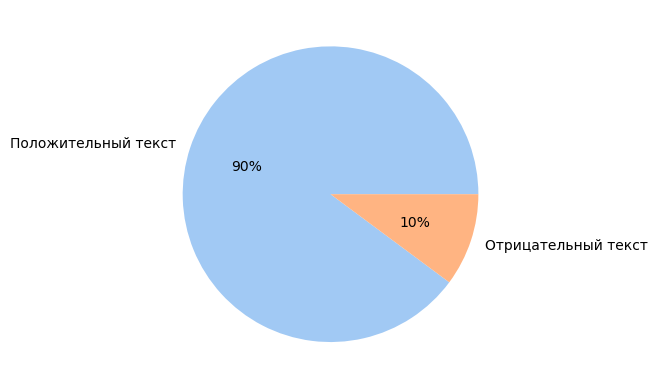

In [22]:
# баланс целевого признака
data = [df['toxic'].value_counts()[0], df['toxic'].value_counts()[1]]
labels = ['Положительный текст', 'Отрицательный текст']

colors = sns.color_palette('pastel')[ 0:5 ]

plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

- Присутствует дисдаланс классов в целевоц переменной, это надо учесть при обучении моделей.

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Обработка данных
    
</div>

Для предобработки данных используем предобученную модель BERT

In [64]:
import torch
import transformers
from tqdm import notebook

In [25]:
# инициализация токенизатора
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

__Проверим длинну текстов__

In [31]:
print(f'Максимальная длинна текста составляет: {max(map(len, df["text"]))} символов')

Максимальная длинна текста составляет: 5000 символов


In [32]:
print(f'Максимальная длинна текста составляет: {min(map(len, df["text"]))} символов')

Максимальная длинна текста составляет: 5 символов


- Стандартная версия модели BERT ('bert-base-cased') имеет ограничение на максимальную длину последовательности, и это ограничение составляет 512 токенов. Это связано с ограниченной памятью графических процессоров (GPU) и вычислительной сложностью обработки более длинных последовательностей при обучении модели.
- Мы можем разделить длинные тексты на более короткие части, учитывая минимальную длинну изначальных текстов, тем самым увеличим датафрейм и стандартизируем данные для правильной работы молели BERT

### Обработка длинных текстов

In [72]:
# максимальная длина последовательности
max_seq_length = 500
# минимальная длина последовательности (5)
min_seq_length = min(map(len, df["text"]))

In [73]:
# список для новых строк
new_rows = []
# функция для разделения
def split(x):
    # разделение на части
    chunks = [x['text'][i:i + max_seq_length] for i in range(0, len(x['text']), max_seq_length)]
    # cоздание новых строк для каждой части
    for chunk in chunks:
        if len(chunk) >= min_seq_length:
            new_row = {'text': chunk, 'toxic': x['toxic']}
            new_rows.append(new_row)
            
df.apply(split, axis=1)
print('Список стандартизированных строк готов')

Список стандартизированных строк готов


In [74]:
# создание обновленного датасета и вывод основной информации
df_split = pd.DataFrame(new_rows)
print(df_split.info())
display(df_split.head(2))
print(f'Датасет увеличился на {(len(df_split)-len(df))/len(df):.0%}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224778 entries, 0 to 224777
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    224778 non-null  object
 1   toxic   224778 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0


Датасет увеличился на 41%


### Токенизация

In [75]:
# токенизация данных
tokenized = df_split['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

### Паддинг данных

In [76]:
# максимальная длина среди токенов
max_len = max(map(len, tokenized))
print(f' Максимальная длина среди токенов составляет: {max_len}')

 Максимальная длина среди токенов составляет: 502


In [77]:
# паддинг данных
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized])

# создание маски внимания
attention_mask = np.where(padded != 0, 1, 0)

In [78]:
min(map(len, padded))

502

### Эмбеддинги текста

In [79]:
# загрузка конфигурации
config = transformers.BertConfig.from_pretrained('bert-base-cased')

# загрузка модели
model = transformers.BertModel.from_pretrained('bert-base-cased', config=config)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [84]:
import torch
from tqdm.notebook import tqdm

batch_size = 250
embeddings = []

# Переносим модель на Metal Performance Shaders (MPS)
device = torch.device("mps")
model.to(device)

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[1].cpu().numpy())

  0%|          | 0/899 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [83]:
print (torch.backends.mps.is_available()) #macOS выше 12.3+ 
print (torch.backends.mps.is_built()) #MPS активирован

True
True


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны